In [5]:
%config ZMQInteractiveShell.ast_node_interactivity='all'
%matplotlib inline
import warnings;warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as spstats
from sklearn import metrics
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin, clone
from sklearn.preprocessing import Imputer, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.externals import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [76]:
target = '标签'
uid = '申请编号'
uid_h = '历史申请编号'

def get_time():
    now = datetime.datetime.now().strftime("%m-%d %H:%M")
    print(now)

def calc_auc(y_test, y_proba):
    auc = round(metrics.roc_auc_score(y_test, y_proba), 3)
    return auc

def ks_score(y_test, y_proba):
    scale = 4
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba, pos_label=1)
    KS = round(max(list(tpr-fpr)), scale)
    return KS

In [33]:
############## D12

d0 = pd.read_csv('./data/train_label.csv')
d1 = pd.read_csv('./data/train_Application.csv')
d2 = pd.read_csv('./data/train_Personas.csv')

d12 = pd.merge(d0, d1, how='inner', on='申请编号')
d12 = pd.merge(d12, d2, how='inner', on='申请编号')
d12.shape
d12.head()

(140000, 63)

,申请编号,标签,贷款类型,信用额度,贷款年金,商品价格,陪同申请人,出生日期距申请日期天数,工作日期距申请日期天数,注册日期距申请日期天数,...,地址是否一致标志3,地址是否一致标志4,地址是否一致标志5,地址是否一致标志6,单位类型,社交圈违约信息2_2,社交圈违约信息2_1,社交圈违约信息1_2,社交圈违约信息1_1,最近一次换手机号码距申请日天数
0,0,1,0,460190.889355,17463.042019,419951.511045,7.0,-10107,-342,-5421,...,0,0,0,0,5,0.0,0.0,0.0,0.0,-887.0
1,1,0,0,424370.659603,15585.046388,384597.975692,7.0,-13980,-1110,-3387,...,0,0,0,1,5,0.0,0.0,0.0,0.0,-271.0
2,2,0,0,469330.587153,18837.558252,419951.511045,1.0,-13331,-2246,-3870,...,1,0,0,0,5,0.0,0.0,0.0,0.0,-332.0
3,3,0,0,464188.353140,16754.587069,409850.500944,7.0,-16540,292204,-970,...,0,0,0,0,57,1.0,0.0,1.0,0.0,-204.0
4,5,0,0,434196.988738,16165.009200,394698.985793,7.0,-17919,-11037,-9350,...,1,1,0,1,53,0.0,0.0,0.0,0.0,-1049.0


In [34]:
###################### 分群？

### Merge pred
d_score = pd.read_csv('./model/predict_train.csv', header=0, index_col=0)
d_score.rename(columns={'0':'score'}, inplace=True)
d_score.shape
d_score.head()

d12s = pd.merge(d_score, d12, how='left', on=uid)
d12s.shape
d12s.head()

(140000, 2)

,申请编号,score
0,0,0.409777
1,1,0.249499
2,2,0.170230
3,3,0.066397
4,5,0.044140


(140000, 64)

,申请编号,score,标签,贷款类型,信用额度,贷款年金,商品价格,陪同申请人,出生日期距申请日期天数,工作日期距申请日期天数,...,地址是否一致标志3,地址是否一致标志4,地址是否一致标志5,地址是否一致标志6,单位类型,社交圈违约信息2_2,社交圈违约信息2_1,社交圈违约信息1_2,社交圈违约信息1_1,最近一次换手机号码距申请日天数
0,0,0.409777,1,0,460190.889355,17463.042019,419951.511045,7.0,-10107,-342,...,0,0,0,0,5,0.0,0.0,0.0,0.0,-887.0
1,1,0.249499,0,0,424370.659603,15585.046388,384597.975692,7.0,-13980,-1110,...,0,0,0,1,5,0.0,0.0,0.0,0.0,-271.0
2,2,0.170230,0,0,469330.587153,18837.558252,419951.511045,1.0,-13331,-2246,...,1,0,0,0,5,0.0,0.0,0.0,0.0,-332.0
3,3,0.066397,0,0,464188.353140,16754.587069,409850.500944,7.0,-16540,292204,...,0,0,0,0,57,1.0,0.0,1.0,0.0,-204.0
4,5,0.044140,0,0,434196.988738,16165.009200,394698.985793,7.0,-17919,-11037,...,1,1,0,1,53,0.0,0.0,0.0,0.0,-1049.0


In [68]:
########### 分群by['商品价格']<445709

uids0 = d12s.loc[(d12s['商品价格']<445709) | (d12s['商品价格'].isna()==True), uid]
uids0.shape
uids0.to_csv('./tmp/train_uid0.csv')
uids1 = d12s.loc[d12s['商品价格']>=445709, uid]
uids1.shape
uids1.to_csv('./tmp/train_uid1.csv')

(104367,)

(35633,)

In [64]:
f='商品价格'
d12s[f].describe()
d12s[f].isna().sum()

count    139880.000000
mean     429468.479262
std       41142.193912
min      374496.965591
25%      396214.137308
50%      419951.511045
75%      445709.086803
max      823991.915085
Name: 商品价格, dtype: float64

120

In [69]:
ks_score(d12s[target], d12s['score'])

f = '商品价格'
for d in d12s.loc[d12s[f]<419951, :], d12s.loc[d12s[f]>419951, :]:
# f = '信用额度'
# for d in d12s.loc[d12s[f]<437110, :], d12s.loc[d12s[f]>506177, :]:
# f = '贷款类型'
# for d in d12s.loc[d12s[f]==0, :], d12s.loc[d12s[f]==1, :]:
    d.shape
    ks_score(d[target], d['score'])

0.7393

(60549, 64)

0.7246

(79331, 64)

0.7518

In [ ]:
############## D3

d3= pd.read_csv('./data/train_History_Application.csv', header=0)
d3.shape
d3.head()

d4= pd.read_csv('./data/train_History_Payment.csv', header=0)
d4.shape
d4.head()

In [ ]:
####### D1 ~ D4 Exploration

# D3
d3_info = {}

d3_info['desc'] = d3.drop([uid, uid_h], axis=1).describe().T
d3_info['desc'].to_csv(f'./ana/0_cols_desc3.csv')

# D4
d4_info = {}

d4_info['desc'] = d4.drop([uid, uid_h], axis=1).describe().T
d4_info['desc'].to_csv(f'./ana/0_cols_desc4.csv')

In [ ]:
d3['合同状态'].value_counts()

In [ ]:
d4.loc[d4[uid]==173562, :].T.to_csv(f'./ana/9_t4_case1.csv')

In [117]:
################  Load Features

''' Load '''
Xid = pd.read_csv('./tmp/train_d1234.csv', header=0, index_col=0)
Xid.shape

Xid1 = pd.read_csv('./tmp/d12_ori.csv', header=0, index_col=0)
Xid1.shape

Xid = pd.merge(Xid, Xid1, on=uid, how='left')

yid = pd.read_csv('./data/train_label.csv', header=0, index_col=0)
yid.shape

''' Merge '''
xy = pd.merge(Xid, yid, on=uid, how='inner')
# xy.drop(uid, axis=1, inplace=True)
xy.shape

# ''' Split '''
# # X, y
# X = xy.copy()
# y = X.pop(target)
# X.shape
# y.shape

' Load '

(140000, 802)

(161511, 82)

(140000, 1)

' Merge '

(140000, 884)

In [3]:
# For kfold
n_folds = 5

# RF
param_fixed_rf = {
    'n_jobs' : 1,
    'oob_score' : True,
    'random_state':123,
    'verbose':0
}

# XGB
param_fixed_xgb = {
    'n_jobs' : 1,
    'eval_metric': 'auc',
    'seed' : 123,
    'silent' : 1,
    'verbose_eval':0
}

# LGB
param_fixed_lgb = {
    'n_jobs' : 1,
    'metric' : 'auc',
    'bagging_seed':123,
    'feature_fraction_seed':123,
    'verbose_eval' : 0
}

In [ ]:
############# boxcox

# feat = '商品价格'
# feat = '贷款申请前1年内征信查询次数'
feat = '出生日期距申请日期天数'

X[feat].describe()

In [ ]:
''' ori '''
sns.distplot(X[feat] + 1)
plt.show()

''' boxcox '''
inp = X[feat].apply('abs') + 1
l, opt_lmbda = spstats.boxcox(inp)
opt_lmbda
lmbda = 0
if opt_lmbda > 0:
    lmbda = opt_lmbda
sns.distplot(spstats.boxcox(inp, lmbda=lmbda))
plt.show()

In [ ]:
############## Fill Null

# Fill Null
imp =Imputer(missing_values=np.NaN, strategy="mean", axis=0)
data = imp.fit_transform(data_ori)
len(data)
len(data[0])

In [ ]:
############## X, y

''' y '''
y = data[:, 1]
len(y)
y[:10]

''' X '''
X = data[:, 2:]
len(X)
len(X[0])
X[0][:10]

pd.DataFrame(y).to_csv('./tmp/1_y.csv')
pd.DataFrame(X).to_csv('./tmp/1_X.csv')

In [ ]:
############## Check X, y

X1 = pd.read_csv('./tmp/1_X.csv', header=0, index_col=0)
X1.shape
X1.head()

y1 = pd.read_csv('./tmp/1_y.csv', header=0, index_col=0)
y1.shape
y1.head()

''' y '''
len(y)
y2 = y1['0'].values
len(y2)
(y == y2).sum()

''' X '''
len(X)
len(X[0])
X2 = X1.values
len(X2)
len(X2[0])
(X == X2).sum(axis=1)
140000 * 329

In [ ]:
n=0
y[n]
y2[n]

In [ ]:
f = '信用额度'
d1234[f].describe()
lmbda[f]

sns.distplot(d1234[f])

In [ ]:
### BoxCox

def get_boxcox(x):
    inp = x.apply('abs') + 1
    l, opt_lmbda = spstats.boxcox(inp)
    opt_lmbda
    lmbda = 0
    if opt_lmbda > 0:
        lmbda = opt_lmbda
    ret = spstats.boxcox(inp, lmbda=lmbda)
    return lmbda, ret

# Features
large_feats_drop = ('申请编号', '客户收入', '身份认证日期距申请日期天数')
large_feats_max = set(d1234.max()[d1234.max()>100].index)
large_feats_min = set(d1234.min()[d1234.min()<-100].index)
len(large_feats_max)
len(large_feats_min)
large_feats = large_feats_max.union(large_feats_min).difference(large_feats_drop)
len(large_feats)

lmbda = {}
for f in large_feats:
    lmbda[f], d1234[f] = get_boxcox(d1234[f])
    
#     f
#     sns.distplot(d1234[f])
#     plt.show()
#     sns.distplot(a)
#     plt.show()

In [ ]:
#### Polynomial

# [年龄20/25/30，教育程度_1/4，性别，if工作时间<，收入类型_7]

''' Feats  Poly '''
feats = np.load('./tmp/0_feats_poly.npy', allow_pickle=True).item()
len(feats)

# Poly
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
feats_poly = pd.DataFrame(poly.fit_transform(d1234[feats]), columns=poly.get_feature_names()).iloc[:, len(feats):]
feats_poly.shape

''' BoxCox '''
# BoxCox
large_feats_max = set(feats_poly.max()[feats_poly.max()>100].index)
large_feats_min = set(feats_poly.min()[feats_poly.min()<-100].index)
len(large_feats_max)
len(large_feats_min)
large_feats = large_feats_max.union(large_feats_min).difference(large_feats_drop)
len(large_feats)

lmbda = {}
for f in large_feats:
    lmbda[f], feats_poly[f] = get_boxcox(feats_poly[f])

''' Concat '''
pd.concat([d1234, feats_poly], axis=1)

In [356]:
str = '贷款年金mean'
xy.columns[xy.columns.str.contains(str)].sort_values(ascending=False)

Index(['贷款年金mean_y', '贷款年金mean_x'], dtype='object')

****** 贷款年金mean_y ******


' 是否有空值 '

0

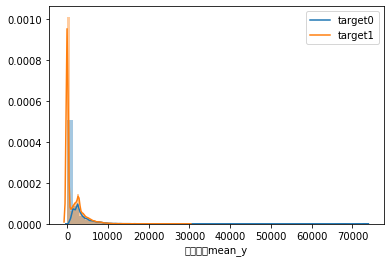

' 分布 '

target0


count    119000.000000
mean       1050.395131
std        2125.966698
min           0.000000
25%           0.000000
50%           0.000000
75%        1500.000000
max       73589.000000
Name: 贷款年金mean_y, dtype: float64

target1


count    21000.000000
mean      1317.436313
std       2097.564514
min          0.000000
25%          0.000000
50%          0.000000
75%       2374.259258
max      29597.000000
Name: 贷款年金mean_y, dtype: float64

****** 贷款年金mean_x ******


' 是否有空值 '

0

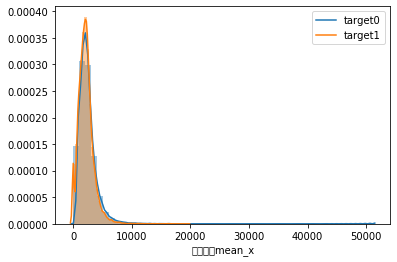

' 分布 '

target0


count    119000.000000
mean       2359.700763
std        1574.409472
min           0.000000
25%        1412.097940
50%        2145.994023
75%        2975.235057
max       51114.000000
Name: 贷款年金mean_x, dtype: float64

target1


count    21000.000000
mean      2182.489449
std       1309.203912
min          0.000000
25%       1344.000000
50%       2055.492528
75%       2773.058764
max      19420.000000
Name: 贷款年金mean_x, dtype: float64

In [357]:
############## Top Features

for f in xy.columns[xy.columns.str.contains(str)].sort_values(ascending=False):
    print(f'****** {f} ******')
    ''' 是否有空值 '''
    ifna = xy[f].isna().sum()
    ifna
    if ifna:
        xy.loc[xy[f].isna()==True, target].mean()
    
    for t in range(2):
#         d = round(xy.loc[xy[target]==t, f] / 10000)
        d = xy.loc[xy[target]==t, f]
        sns.distplot(d[d.isna()==False], kde_kws={'label':f'target{t}'})
    plt.show()
    ''' 分布 '''
    for t in range(2):
        print(f'target{t}')
#         d = round(xy.loc[xy[target]==t, f] / 10000)
        d = xy.loc[xy[target]==t, f]
        d.describe()

In [331]:
a = xy[[target, '贷款类型_x', '身份认证日期距申请日期月数_y']].head(100)
poly = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
feats_poly = pd.DataFrame(poly.fit_transform(a), columns=poly.get_feature_names()).iloc[:, len(a.columns):]
feats_poly.head()

,x0 x1,x0 x2,x1 x2,x0 x1 x2
0,0.0,-110.0,-0.0,-0.0
1,0.0,-0.0,-0.0,-0.0
2,0.0,-0.0,-0.0,-0.0
3,0.0,-0.0,-0.0,-0.0
4,0.0,-0.0,-0.0,-0.0


In [318]:
f = '工作日期距申请日期天数_y'
v = -2
round(xy.loc[(xy[f]/365<=v) & (xy[f].isna()==False), target].mean() ,3)
round(xy.loc[(xy[f]/365>v) & (xy[f]<0) & (xy[f].isna()==False), target].mean() ,3)

0.132

0.204